In [394]:
# histogram number of spectra per star, and number o nights of observing
# want to make a csv file for bookeeping. Which fits files are used for what star, which get thrown out where and why

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits

apf_log_file =  pd.read_csv('apf_log_full_current.csv')
all_apf_results = pd.read_csv('SM_stellar_properties/all_apf/11Jan2022/specmatch_results_11Jan2022.csv')
all_obs_results = pd.read_csv('SM_stellar_properties/all_obs/8Apr2022/specmatch_results_all_obs_8Apr2022.csv')
all_ind_results = pd.read_csv('SM_stellar_properties/ind/8Apr2022/specmatch_results_ind_8Apr2022.csv')


Median 4 nights of observing per star.
Min 1 and max 71 nights of observing per star.


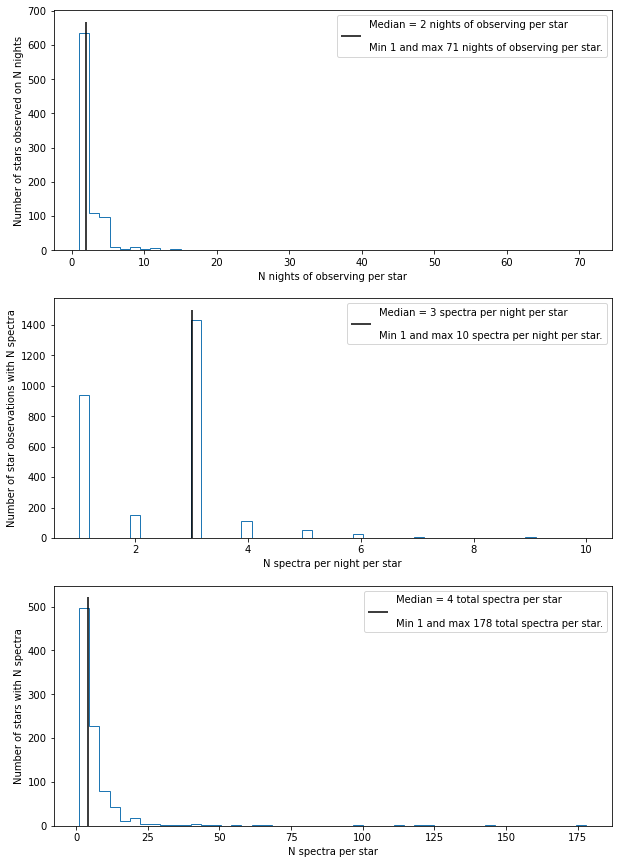

In [42]:
# histogram number of observing nights per star, total spectra per star

stars_nights = os.listdir('APF_spectra/all_apf_spectra_by_obs') # format is starname_idx#
stars_w_repeats = [name.split('_')[0] for name in stars_nights]
unique_stars = sorted(set(stars_w_repeats))
num_obs = np.zeros(len(unique_stars)) * np.nan
num_spectra_tot = np.zeros(len(unique_stars)) 
num_spectra_per_obs = np.zeros(len(stars_w_repeats)) * np.nan
for i in range(len(unique_stars)):
    star = unique_stars[i]
    num = stars_w_repeats.count(star)
    num_obs[i] = int(num)

for i in range(len(stars_nights)):
    star_idx = stars_nights[i]
    star = star_idx.split('_')[0]
    num_spectra_per_obs[i] = len(os.listdir('APF_spectra/all_apf_spectra_by_obs/' + star_idx))
    star_idx = unique_stars.index(star)
    num_spectra_tot[star_idx] += num_spectra_per_obs[i] 
    

plt.figure(figsize = [10,15])
plt.subplot(311)
median = np.nanmedian(num_obs)
plt.hist(num_obs, bins = 50, histtype = 'step')
ax = plt.gca()
plt.vlines([median], ymin = 0, ymax = ax.get_ylim()[1], label = 'Median = ' + str(int(median)) + ' nights of observing per star' +
          '\n\nMin ' + str(int(np.nanmin(num_obs))) + ' and max ' + str(int(np.nanmax(num_obs))) + ' nights of observing per star.')
plt.xlabel('N nights of observing per star')
plt.ylabel('Number of stars observed on N nights')
plt.legend()

plt.subplot(312)
median = np.nanmedian(num_spectra_per_obs)
plt.hist(num_spectra_per_obs, bins = 50, histtype = 'step')
ax = plt.gca()
plt.vlines([median], ymin = 0, ymax = ax.get_ylim()[1], label = 'Median = ' + str(int(median)) + ' spectra per night per star' +
          '\n\nMin ' + str(int(np.nanmin(num_spectra_per_obs))) + ' and max ' + str(int(np.nanmax(num_spectra_per_obs))) + ' spectra per night per star.')
plt.xlabel('N spectra per night per star')
plt.ylabel('Number of star observations with N spectra')
plt.legend()

plt.subplot(313)
median = np.nanmedian(num_spectra_tot)
plt.hist(num_spectra_tot, bins = 50, histtype = 'step')
ax = plt.gca()
plt.vlines([median], ymin = 0, ymax = ax.get_ylim()[1], label = 'Median = ' + str(int(median)) + ' total spectra per star' +
          '\n\nMin ' + str(int(np.nanmin(num_spectra_tot))) + ' and max ' + str(int(np.nanmax(num_spectra_tot))) + ' total spectra per star.')
plt.xlabel('N spectra per star')
plt.ylabel('Number of stars with N spectra')
plt.legend()

print('Median ' + str(int(median)) + ' nights of observing per star.')
print('Min ' + str(int(np.nanmin(num_obs))) + ' and max ' + str(int(np.nanmax(num_obs))) + ' nights of observing per star.')

In [622]:
# Can we cut for the stars that have 3+ obs per night
# (the above is not specifically for the ind dataset)
used_resids = pd.read_csv('Residual_list_all_ind_5-14-22.csv')['Filename']
unique_star_names = list(set([name.split('_')[0] for name in used_resids]))
#for i in range(len(used_resids)):
#    id_name = used_resids[i].split('_')[0] + '_' + used_resids[i].split('_')[1]
#    fits_file = list(all_ind_results[all_ind_results['name'] == id_name]['filenames'])[0].strip('[').strip(']').strip('\'')
#    date = 
#    print(fits_file)

max_obs_per_night = np.zeros(len(unique_star_names)) * np.nan
skipped = []
num_spect_excluded = 0
num_spect_included = 0
for i in range(len(unique_star_names)):
    star = unique_star_names[i]
    try:
        files = all_ind_results[all_ind_results['Simbad_resolvable_name'] == star]['filenames']
        dates = []
        for file in files:
            file = file.strip('[').strip(']').strip('\'')
            datetime = list(apf_log_file[apf_log_file['Filename'] == file]['Date_obs'])[0] # shoulbe be in UTC, such that 06:00:00 is 11pm PT
            dates += [datetime.split('T')[0]]
        counts = []    
        for date in set(dates):
            counts += [dates.count(date)]
            #print(date + ' occurs ' + str(count) + ' times.')
        max_obs_per_night[i] = np.max(counts)
        for count in range(len(counts)):
            if count < 3: num_spect_excluded += count
            elif count >= 3: num_spect_included += count
    except ValueError:
        print('skipping ' + star + ', could not find any files for this star in the results file.')
        skipped += [star]

print('Skipped ' + str(len(skipped)) + ' total residuals.')
# it skips HIP42172, HIP56445 etc, which have iodine, and some NGC's, which are galaxies, -- how did these make it into the list of residuals to use?

 # WHY is len(unique_star_names) = 433 not the same as what I found in the other noteboook (387)???   

Skipped 0 total residuals.


In [624]:
nanmask = np.invert(np.isnan(max_obs_per_night))
print('total number unique stars:                   ' + str(len(max_obs_per_night[nanmask])))
print('number stars with no night >3 obs:           ' + str(len(np.where(max_obs_per_night[nanmask] < 3)[0])))
print('number stars with at least one night >3 obs: ' + str(len(np.where(max_obs_per_night[nanmask] >= 3)[0])))
  
print('approximate number spectra excluded from this cut ' + str(num_spect_excluded))
print('approximate number spectra included from this cut ' + str(num_spect_included))

total number unique stars:                   433
number stars with no night >3 obs:           45
number stars with at least one night >3 obs: 388
approximate number spectra excluded from this cut 575
approximate number spectra included from this cut 265


In [ ]:
# check that the cut on chi square is still relevent
chi_sq1 = all_apf_results['best_mean_chi_squared']
plt.figure(figsize = [20,15])
plt.subplot(311)
t = 15
bins = np.logspace(0, 3.5,100)
#bins = 1000
#bins = np.linspace(0,100,50)
plt.hist(chi_sq1, bins = bins,histtype = 'step')
plt.vlines([t], ymin = 0, ymax = 50, ls = 'dashed', label = 'Threshold (chi square = 8)')
plt.xlabel('Chi square value')
plt.ylabel('Number of targets')
plt.title('Highest SNR set')
plt.legend()
#plt.semilogy()
plt.semilogx()
#plt.figure(figsize = [15,5])
plt.subplot(312)
chi_sq2 = all_obs_results['best_mean_chi_squared']
plt.hist(chi_sq2, bins = bins ,histtype = 'step')
plt.vlines([t], ymin = 0, ymax = 120, ls = 'dashed', label = 'Threshold (chi square = 8)')
plt.xlabel('Chi square value')
plt.title('All observations set')
plt.legend()
#plt.semilogx()
#plt.figure(figsize = [15,5])
plt.subplot(313)
chi_sq3 = all_ind_results['best_mean_chi_squared']
plt.hist(chi_sq3, bins = bins ,histtype = 'step')
plt.vlines([t], ymin = 0, ymax = 250, ls = 'dashed', label = 'Threshold (chi square = 8)')
plt.title('Individual spectra')
plt.xlabel('Chi square value')
plt.legend()
#plt.semilogx()


print(len(np.where(chi_sq3 > 15)[0]))
#print(len(np.where(chi_sq1 > 8)[0]))
print(np.nanmax(chi_sq1))

In [ ]:
# distance
from astroquery.simbad import Simbad
Simbad.add_votable_fields('distance')
names = all_apf_results['Simbad_resolvable_name']
dists = []
for i in range(len(all_apf_results[0:20])):
    name = names[i]
    table1 = Simbad.query_object(name).to_pandas()
    d = table1['Distance_distance']
    u = list(table1['Distance_unit'])[0]
    if u == 'pc': d = d * 3.26156
    elif u == 'kpc': d = d * 3261.56      
    elif u == 'Mpc': d = d * 3.26156 * 10**6
    if np.isnan(list(d)[0]): print('Nan distance: ' + name)
    #print(str(list(d)[0]) + ' ly')
    dists += list(d)
    

No handles with labels found to put in legend.


126.39653930399999

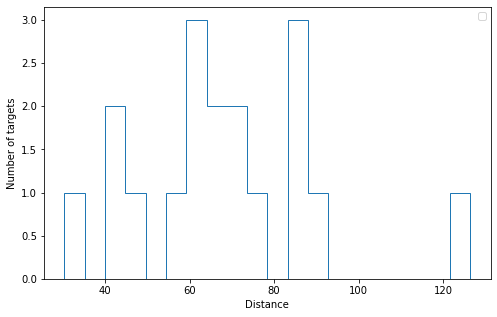

In [318]:
plt.figure(figsize = [8,5])
plt.hist(dists, bins = 20, histtype = 'step')
plt.xlabel('Distance')
plt.ylabel('Number of targets')
plt.legend()
np.nanmax(dists)

## File bookeeping 

In [195]:
# total number of targets and files in BL database

SM_log = apf_log_file.copy()

all_files = apf_log_file['Filename']
names = apf_log_file['Simbad_resolvable_name']
paths = apf_log_file['Filepath']
#iodine_flag = apf_log_file['Iodine_cell']
binary_flag = list(apf_log_file['Known_binary'] | (apf_log_file['Main_type'] == 'SB*'))

run1_stars = [name.split('_')[0] for name in os.listdir('APF_spectra/all_apf_spectra_highest_SNR')] # initial list of all target names read in for that run, even if failed due to iodine, binary, etc.
run1_resid_stars = [name.split('_')[0] for name in os.listdir('APF_spectra/NDRR_all_apf')] # initial list of all target names read in for that run, even if failed due to iodine, binary, etc.
run1_files = []
for (a, b, c) in os.walk('APF_spectra/all_apf_spectra_highest_SNR'): run1_files += c
    
run2_stars = [name.split('_')[0] for name in os.listdir('APF_spectra/all_apf_spectra_by_obs')] # initial list of all target names read in for that run, even if failed due to iodine, binary, etc.
run2_resid_stars = [name.split('_')[0] for name in os.listdir('APF_spectra/NDRR_all_obs')] # initial list of all target names read in for that run, even if failed due to iodine, binary, etc.
run2_files = []
for (a, b, c) in os.walk('APF_spectra/all_apf_spectra_by_obs'): run2_files += c
    
run3_stars = [name.split('_')[0] for name in os.listdir('APF_spectra/all_individual_spectra')] # initial list of all target names read in for that run, even if failed due to iodine, binary, etc.
run3_resid_stars = [name.split('_')[0] for name in os.listdir('APF_spectra/NDRR_ind')] # initial list of all target names read in for that run, even if failed due to iodine, binary, etc.
run3_files = []
for (a, b, c) in os.walk('APF_spectra/all_individual_spectra'): run3_files += c
    
    
attempted_run1 = np.zeros(len(all_files)) * np.nan
attempted_run2 = np.zeros(len(all_files)) * np.nan
attempted_run3 = np.zeros(len(all_files)) * np.nan 
success_run1 = np.zeros(len(all_files)) * np.nan
success_run2 = np.zeros(len(all_files)) * np.nan
success_run3 = np.zeros(len(all_files)) * np.nan 

for i in range(len(all_files)):
    filename = all_files[i]
    name = names[i]
    attempted_run1[i] =  int(filename in run1_files) # was it used in highest snr run
    success_run1[i] = int(attempted_run1[i]  *  (name in run1_resid_stars)) # did that star produce a residual in run1 *using this file*
    attempted_run2[i] =  int(filename in run2_files) # was it used in highest snr run
    success_run2[i] = int(attempted_run2[i]  *  (name in run2_resid_stars)) # did that star produce a residual in run2 *using this file*
    attempted_run3[i] =  int(filename in run3_files) # was it used in highest snr run
    success_run3[i] = int(attempted_run3[i]  *  (name in run3_resid_stars)) # did that star produce a residual in run3 *using this file*

#    Add the following to essentially the log file
#    has iodine
#    object type
#    binary flag
#    non-stellar flag

SM_log.insert(7, "Resid_run_3", success_run3.astype(bool))
SM_log.insert(7, "Resid_run_2", success_run2.astype(bool))
SM_log.insert(7, "Resid_run_1", success_run1.astype(bool))
SM_log.insert(7, "In_dataset_3", attempted_run3.astype(bool))
SM_log.insert(7, "In_dataset_2", attempted_run2.astype(bool))
SM_log.insert(7, "In_dataset_1", attempted_run1.astype(bool))
SM_log['Known_binary'] = binary_flag


In [196]:
SM_log.to_csv('SM_log_file2.csv', index = False)


In [116]:
# histogram exposure time
exp_times = []
for file in os.listdir('/datax/scratch/hisaacson/data'):
    if os.path.isfile('/datax/scratch/hisaacson/data/' + file) and file.startswith('r') and file.endswith('fits'):
        hdu = fits.open('/datax/scratch/hisaacson/data/' + file)
        exp_time = hdu[0].header['EXPTIME']
        exp_times += [exp_time]
    
for file in os.listdir('/datag/blpd0/datax/apf'):
    if os.path.isfile('/datax/scratch/hisaacson/data/' + file) and file.startswith('r') and file.endswith('fits'):
        hdu = fits.open('/datag/blpd0/datax/apf/' + file )
        exp_time = hdu[0].header['EXPTIME']
        exp_times += [exp_time]
    

2.58
1200.0
727.68


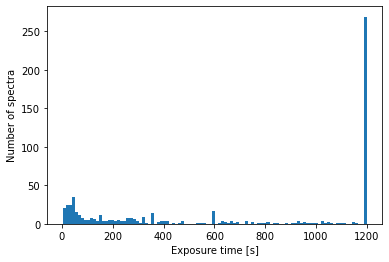

In [372]:
plt.hist(exp_times, bins = 100)
plt.xlabel('Exposure time [s]')
plt.ylabel('Number of spectra')
print(np.min(exp_times))
print(np.max(exp_times))
print(np.nanmedian(exp_times))


In [419]:
all_files = apf_log_file['Filename']
sim_names = apf_log_file['Simbad_resolvable_name']

# Totals
N_tot_spect = len(SM_log) # = len(SM_log['In_dataset_1']), ~ len(all_ind_results), but I think there are some extras in the log that aren't really stellar spectra
# highest SNR
N_tot = len(all_apf_results) #  = len(run1_stars), and should equal len(set(run2_stars)) and len(set(run3_stars)))
N_tot_spect_all_apf = len(np.where(SM_log['In_dataset_1'] == True)[0])
# all obs
N_tot_all_obs = len(all_obs_results) # len(run2_stars)
N_tot_spect_all_obs = len(np.where(SM_log['In_dataset_2'] == True)[0])
# ind
N_tot_ind = len(run3_stars) # NOTE: in contrast to runs 1 and 3, this is NOT the same number as len(all_ind_results), 
                            #       becuase we preemptively skipped binaroes, iodine, etc. for that run. 

    
# How many of all the targets were binary/non-stellar? How many spectra?
N_not_stars =  len(all_apf_results[all_apf_results['binary_flag'] | all_apf_results['non-stellar_flag']])
N_spect_not_stars = len(SM_log[SM_log['Known_binary'] | SM_log['Known_non-stellar']])

# How many of all the targets had iodine? How many spectra (careful bc target flagged for iodine if even one spectrum had it)?
N_iod =  len(all_apf_results[all_apf_results['iodine_flag'] == 1.0])
N_spect_iod = len(SM_log[SM_log['Iodine_cell'] == 'In'])

# how many failed the chi square cut?
N_chi_sq_all_apf = len(all_apf_results[all_apf_results['best_mean_chi_squared'] > 15])
N_chi_sq_all_obs = len(all_obs_results[all_obs_results['best_mean_chi_squared'] > 15])
N_chi_sq_ind = len(all_ind_results[all_ind_results['best_mean_chi_squared'] > 15])

# how many spectra are in the all_obs (or ind) dataset, that DON'T get cut due to iodine, non-stellar, Teff, or chi_square?
num_excluded_spectra = 0
for i in range(len(all_files)):
    try:
        filename = all_files[i]
        name = sim_names[i]
        #print(name)
        # these stars for some reason have a different sim name in the results file compared with the log file. Both resolve in Simbad.
        if name == 'HIP74981': name = 'TIC357501308'  
        if name == 'eta_Crv': name = 'HIP61174'
        if name == 'eps_Cep': name = 'HIP109857'
        if name == 'alderamin': name = 'HIP105199'
        if name == 'Altair': name = 'HIP97649'
        if name == 'HD109085': name = 'HIP61174'    
        if name == 'HD172167': name = 'HIP91262'
        if name == 'HD187642': name = 'HIP97649'        
        if name == 'SAO82649': name = 'HIP63942'
        if name == 'HD211336': name = 'HIP105199'        
        if name == 'HD28355': name = 'HIP20901'
        if name == 'HD109085': name = 'HIP61174'
        if name == 'HD203280': name = 'HIP105199'
        if name == 'b_Tau': name = 'HIP20901'
        if name.startswith('NGC'):
            num_excluded_spectra += 1
            continue
        log_row = SM_log[SM_log['Filename'] == filename]
        results_row = all_apf_results[all_apf_results['Simbad_resolvable_name'] == name]
        tf = log_row['Known_binary'] | log_row['Known_non-stellar'] | (log_row['Iodine_cell'] == 'In') | list(results_row['Teff_bounds_flag'] != 0) | list(results_row['R_bounds_flag'] != 0) | list(results_row['best_mean_chi_squared'] > 8)
        if list(tf)[0]: num_excluded_spectra += 1
    except ValueError:
        print('skipping ' + str(name))

    

print()
print('Total number of spectra (in the 2 BL APF directories):' + str(N_tot_spect))
print('Total number of spectra in dataset 1:                 ' + str(N_tot_spect_all_apf))
print('Total number of spectra in dataset 2:                 ' + str(N_tot_spect_all_obs))
print('Total number of spectra in dataset 3:                 ' + str(N_tot_ind))
print('Number spectra non-stellar: ' + str(N_spect_not_stars))
print('Number spectra w/ iodine : ' + str(N_spect_iod))
print('Number spectra failing chi sqaure: ' + str(N_chi_sq_ind))
print()
print('Number targets in set 1:    ' + str(N_tot))
print('Number "targets" in set 2:  ' + str(N_tot_all_obs)) # includes repeats -- there's only as many targets as are in dataset 1
print('Number "targets" in set 3:  ' + str(N_tot_ind)) # includes repeats -- there's only as many targets as are in dataset 1
print()
print('Number targets non-stellar: ' + str(N_not_stars))
print('Number targets w/ iodine (of stellar targets): ' + str(N_iod))
print('Number targets failing chi sqaure test (of all targets): ' + str(N_chi_sq_all_apf))
print()
print('Total number excluded spectra: ' + str(num_excluded_spectra))
print('Total number used spectra: ' + str(N_tot_spect - num_excluded_spectra))


skipping None

Total number of spectra (in the 2 BL APF directories):6482
Total number of spectra in dataset 1:                 2567
Total number of spectra in dataset 2:                 6482
Total number of spectra in dataset 3:                 6461
Number spectra non-stellar: 718
Number spectra w/ iodine : 1379
Number spectra failing chi sqaure: 1242

Number targets in set 1:    902
Number "targets" in set 2:  2719
Number "targets" in set 3:  6461

Number targets non-stellar: 100
Number targets w/ iodine (of stellar targets): 23
Number targets failing chi sqaure test (of all targets): 159

Total number excluded spectra: 4329
Total number used spectra: 2153


In [ ]:
# We ultimateley decided to use just the individual run stars

non_stellar = 0
iodine = 0
Teff = 0
chi_sq = 0
included = 0
non_stellar_list = []
iodine_list = []
Teff_list = []
chi_sq_list = []
included_stars = []
for i in range(len(all_files)):
    try:
        filename = all_files[i]
        name = names[i]
        #print(name)      
        # these stars for some reason have a different sim name in the results file compared with the log file. Both resolve in Simbad.
        if name == 'HIP74981': name = 'TIC357501308'  
        if name == 'eta_Crv': name = 'HIP61174'
        if name == 'eps_Cep': name = 'HIP109857'
        if name == 'alderamin': name = 'HIP105199'
        if name == 'Altair': name = 'HIP97649'
        if name == 'HD109085': name = 'HIP61174'    
        if name == 'HD172167': name = 'HIP91262'
        if name == 'HD187642': name = 'HIP97649'        
        if name == 'SAO82649': name = 'HIP63942'
        if name == 'HD211336': name = 'HIP105199'        
        if name == 'HD28355': name = 'HIP20901'
        if name == 'HD109085': name = 'HIP61174'
        if name == 'HD203280': name = 'HIP105199'
        if name == 'b_Tau': name = 'HIP20901'
        if name == 'None':
            print('skipping ' + str(filename) + ' due to no Simbad resolvable name.')
            continue
        if name.startswith('NGC'):
            non_stellar += 1
            non_stellar_list += [name]
            continue
        log_row = SM_log[SM_log['Filename'] == filename]
        results_row = all_apf_results[all_apf_results['Simbad_resolvable_name'] == name]
        if list(log_row['Known_binary'])[0] | list(log_row['Known_non-stellar'])[0]:
            non_stellar += 1
            non_stellar_list += [name]
        elif list(log_row['Iodine_cell'] == 'In')[0]:
            iodine += 1
            iodine_list += [name]
        elif list(results_row['Teff_bounds_flag'] != 0)[0] | list(results_row['R_bounds_flag'] != 0)[0]:
            Teff += 1
            Teff_list += [name]
        elif list(results_row['best_mean_chi_squared'] > 15)[0]:
            print(results_row['best_mean_chi_squared'])
            chi_sq += 1
            chi_sq_list += [name]
        # if that spectrum was not excluded for any reason    
        if not (list(log_row['Known_binary'] | log_row['Known_non-stellar'] | (log_row['Iodine_cell'] == 'In') | list(results_row['Teff_bounds_flag'] != 0) | list(results_row['R_bounds_flag'] != 0) | list(results_row['best_mean_chi_squared'] > 8))[0]):
            included += 1
            included_stars += [name]
    except ValueError:
        print('skipping ' + str(name))


In [467]:
print('INDIVIDUAL DATASET')
print()
print('Attempted:')
print('   Number spectra: ' + str(len(attempted_run3)))
print('   Number unique stars: ' + str(len(set(run3_stars))))
print()
print('Excluded due to non-stellar or binary:')
print('   Number spectra: ' + str(non_stellar))
print('   Number unique stars: ' + str(len(set(non_stellar_list))))
print()
print('Excluded due to iodine:')
print('   Number spectra: ' + str(iodine))
print('   Number unique stars: ' + str(len(set(iodine_list))) + ' (But, this includes all stars that had a spectrum excluded due to iodine! Could still have made it through with another one.)')
print()
print('Excluded due to Teff:')
print('   Number spectra: ' + str(Teff))
print('   Number unique stars: ' + str(len(set(Teff_list))))
print()
print('Excluded due to chi-sqaure:')
print('   Number spectra: ' + str(chi_sq))
print('   Number unique stars: ' + str(len(set(chi_sq_list))) + ' (But, this includes all stars that had a spectrum excluded due to chi square! Could still have made it through with another one.)')
print()
print('Number included:')
print('   Number spectra: ' + str(included))
print('   Number unique stars: ' + str(len(set(included_stars))))
print()

INDIVIDUAL DATASET

Attempted:
   Number spectra: 6482
   Number unique stars: 896

Excluded due to non-stellar or binary:
   Number spectra: 718
   Number unique stars: 103

Excluded due to iodine:
   Number spectra: 1299
   Number unique stars: 50 (But, this includes all stars that had a spectrum excluded due to iodine! Could still have made it through with another one.)

Excluded due to Teff:
   Number spectra: 1563
   Number unique stars: 282

Excluded due to chi-sqaure:
   Number spectra: 482
   Number unique stars: 74 (But, this includes all stars that had a spectrum excluded due to chi square! Could still have made it through with another one.)

Number included:
   Number spectra: 2152
   Number unique stars: 387



## Why is len(included_stars) = 387 different from len(unique_star_names = 433 above??

In [559]:
set1 = set(included_stars)
set2 = set(unique_star_names)
intersection = list(set(included_stars) & set(unique_star_names))
set1_not_set2 = list(set(included_stars) - set(unique_star_names))
set2_not_set1 = list(set(unique_star_names) - set(included_stars))
print('Number in both: ' + str(len(intersection)))
print('Number in set1 not set2: ' + str(len(set1_not_set2)))
print('Number in set2 not set1: ' + str(len(set2_not_set1)))
print()
print('Stars in one but not the other: ')
print(set2_not_set1)
print(set1_not_set2)

Number in both: 363
Number in set1 not set2: 24
Number in set2 not set1: 70

Stars in one but not the other: 
['HIP87585', 'HIP9487', 'HIP60759', 'HIP23147', 'HIP53486', 'HIP30630', 'HIP63762', 'HIP37288', 'HIP59514', 'HIP46343', 'TIC232540264', 'HIP81348', 'HIP96285', 'HIP63894', 'HIP5286', 'HIP108782', 'HIP30112', 'HIP45038', 'HIP5364', 'HIP103650', 'TIC406672232', 'HIP102101', 'HIP107788', 'HIP23875', 'HIP2', 'HIP18280', 'HIP21482', 'HIP91009', 'HIP106811', 'HIP36152', 'HIP102870', 'HIP57632', 'HIP61094', 'HIP117946', 'HIP6917', 'HIP97051', 'HIP101027', 'HIP16846', 'HIP4436', 'HIP51502', 'HIP32919', 'HIP34950', 'HIP60994', 'HIP90139', 'HIP79607', 'HIP66886', 'HIP14576', 'HIP109378', 'HIP29800', 'HIP69824', 'TIC352413427', 'HIP108092', 'HIP72237', 'HIP6706', 'HIP67808', 'HIP19655', 'HIP5369', 'HIP22288', 'HIP112918', 'HIP110640', 'TIC352764091', 'HIP86032', 'HIP69673', 'HIP70952', 'HIP72044', 'HIP73695', 'HIP89087', 'HIP63467', 'HIP104887', 'HIP105341']
['HIP118310', 'Vega', 'HIP1042

In [555]:
from collections import Counter
Counter(set1)

NameError: name 'set1' is not defined

In [606]:
# try to redo the above to match what actually gets listed in the file

chi_sq_threshold = 15
non_stellar = 0
iodine = 0
Teff = 0
chi_sq = 0
SM_fail = 0 
included = 0
non_stellar_list = []
iodine_list = []
Teff_list = []
chi_sq_list = []
SM_fail_list = []
included_stars = []
included_stars_1 = []
included_stars_2 = []
included_stars_3 = []
included_stars_4 = []
included_stars_5 = []
included_stars_6 = []

apf_data = all_ind_results
names = apf_data['name'].to_list()
star_names = set([name.split('_')[0] for name in names])

for i in range(len(names)):
    name = names[i]
    log_name = name.split('_')[0]
    try:
        apf_row = apf_data[apf_data['name'] == name]
        log_row = apf_log_file[apf_log_file['Simbad_resolvable_name'] == log_name] # not unique to this file but rather the star, ok bc only use for SB*       
        #filename = all_files[i]
        #name = names[i]
        
        '''
        #print(name)      
        # these stars for some reason have a different sim name in the results file compared with the log file. Both resolve in Simbad.
        if name == 'HIP74981': name = 'TIC357501308'  
        if name == 'eta_Crv': name = 'HIP61174'
        if name == 'eps_Cep': name = 'HIP109857'
        if name == 'alderamin': name = 'HIP105199'
        if name == 'Altair': name = 'HIP97649'
        if name == 'HD109085': name = 'HIP61174'    
        if name == 'HD172167': name = 'HIP91262'
        if name == 'HD187642': name = 'HIP97649'        
        if name == 'SAO82649': name = 'HIP63942'
        if name == 'HD211336': name = 'HIP105199'        
        if name == 'HD28355': name = 'HIP20901'
        if name == 'HD109085': name = 'HIP61174'
        if name == 'HD203280': name = 'HIP105199'
        if name == 'b_Tau': name = 'HIP20901'
        if name == 'None':
            print('skipping ' + str(filename) + ' due to no Simbad resolvable name.')
            continue
        if name.startswith('NGC'):
            non_stellar += 1
            non_stellar_list += [name]
            continue
        '''      
       # log_row = SM_log[SM_log['Filename'] == filename]
       # results_row = all_apf_results[all_apf_results['Simbad_resolvable_name'] == name]
        total_stars = set(names)
        if apf_row['iodine_flag'].to_numpy()[0] == 1.0:
            iodine += 1
            iodine_list += [log_name]
        elif (str(apf_row['binary_flag'].to_numpy()[0] == True) == 'True') | apf_row['non-stellar_flag'].to_numpy()[0] == True:
            non_stellar += 1
            non_stellar_list += [log_name]
            #included_stars_2 += [log_name]
        elif apf_row['failure_code'].to_numpy()[0]:
            SM_fail += 1
            SM_fail_list += [log_name]
            #included_stars_3 += [log_name]
            #print(apf_row['failure_message'])
        elif (apf_row['Teff_bounds_flag'].to_numpy()[0] == 1.0) | (apf_row['R_bounds_flag'].to_numpy()[0] == 1.0) | (apf_row['Teff_bounds_flag'].to_numpy()[0] == 3.0) | (apf_row['R_bounds_flag'].to_numpy()[0] == 3.0):
            Teff += 1
            Teff_list += [log_name]   
            #included_stars_4 += [log_name]
        elif log_row['Main_type'].to_numpy()[0] == 'SB*':
            non_stellar += 1
            non_stellar_list += [log_name]  
            #included_stars_5 += [log_name]
        elif apf_row['best_mean_chi_squared'].to_numpy()[0] > chi_sq_threshold:
            #print(apf_row['best_mean_chi_squared'].to_numpy()[0])
            chi_sq += 1
            chi_sq_list += [log_name]
            #included_stars_6 += [log_name]
            
        else:
            included += 1
            included_stars += [log_name]

           
            
        '''
        if list(log_row['Known_binary'])[0] | list(log_row['Known_non-stellar'])[0]:
            non_stellar += 1
            non_stellar_list += [name]
        elif list(log_row['Iodine_cell'] == 'In')[0]:
            iodine += 1
            iodine_list += [name]
        elif list(results_row['Teff_bounds_flag'] != 0)[0] | list(results_row['R_bounds_flag'] != 0)[0]:
            Teff += 1
            Teff_list += [name]
        elif list(results_row['best_mean_chi_squared'] > 15)[0]:
            print(results_row['best_mean_chi_squared'])
            chi_sq += 1
            chi_sq_list += [name]      
        # if that spectrum was not excluded for any reason    
        if not (list(log_row['Known_binary'] | log_row['Known_non-stellar'] | (log_row['Iodine_cell'] == 'In') | list(results_row['Teff_bounds_flag'] != 0) | list(results_row['R_bounds_flag'] != 0) | list(results_row['best_mean_chi_squared'] > 8))[0]):
            included += 1
            included_stars += [name]
        '''
        
    except ValueError:
        print('skipping ' + str(name))


In [620]:
print('INDIVIDUAL DATASET')
print()
print('Attempted:')
print('   Number spectra: ' + str(len(attempted_run3)))
print('   Number spectra attempted: ' + str(len(names)))
print('   Number unique stars: ' + str(len(set(run3_stars))))
print()
print('Excluded due to iodine:')
print('   Number spectra: ' + str(iodine))
print('   Number unique stars: ' + str(len(set(iodine_list))) + ' (But, this includes all stars that had a spectrum excluded due to iodine! Could still have made it through with another one.)')
print()
print('Excluded due to non-stellar or binary:')
print('   Number spectra: ' + str(non_stellar))
print('   Number unique stars: ' + str(len(set(non_stellar_list))))
print()
print('Excluded due to SM fail for other reason:')
print('   Number spectra: ' + str(SM_fail))
print('   Number unique stars: ' + str(len(set(SM_fail_list))) + ' (But, this includes all stars that had a spectrum excluded due to chi square! Could still have made it through with another one.)')
print()
print('Excluded due to Teff or Radius:')
print('   Number spectra: ' + str(Teff))
print('   Number unique stars: ' + str(len(set(Teff_list))))
print()
print('Excluded due to chi-sqaure:')
print('   Number spectra: ' + str(chi_sq))
print('   Number unique stars: ' + str(len(set(chi_sq_list))) + ' (But, this includes all stars that had a spectrum excluded due to chi square! Could still have made it through with another one.)')
print('   Number unique stars: ' + str(len(set(chi_sq_list) - set(included_stars))))
print()
print('Number included:')
print('   Number spectra: ' + str(included))
print('   Number unique stars: ' + str(len(set(included_stars))))
print()

INDIVIDUAL DATASET

Attempted:
   Number spectra: 6482
   Number spectra attempted: 5082
   Number unique stars: 896

Excluded due to iodine:
   Number spectra: 0
   Number unique stars: 0 (But, this includes all stars that had a spectrum excluded due to iodine! Could still have made it through with another one.)

Excluded due to non-stellar or binary:
   Number spectra: 618
   Number unique stars: 96

Excluded due to SM fail for other reason:
   Number spectra: 118
   Number unique stars: 57 (But, this includes all stars that had a spectrum excluded due to chi square! Could still have made it through with another one.)

Excluded due to Teff or Radius:
   Number spectra: 1609
   Number unique stars: 291

Excluded due to chi-sqaure:
   Number spectra: 721
   Number unique stars: 212 (But, this includes all stars that had a spectrum excluded due to chi square! Could still have made it through with another one.)
   Number unique stars: 68

Number included:
   Number spectra: 2016
   Numbe

In [579]:
apf_row['binary_flag'].to_numpy()[0] == True

False

In [591]:
SM_fail

118

In [604]:
6482 - len(names)

1400

In [586]:
apf_row['iodine_flag'].to_numpy()[0]

0.0

In [603]:
 6482 - 5082

1400

In [605]:
used_resids = pd.read_csv('Residual_list_all_ind_5-14-22.csv')['Filename']
len(used_resids)

2016

In [612]:
star_names = set([name.split('_')[0] for name in names])
len(star_names)

891

In [615]:
a = ['a','b','c','d']
b = set(a)
e = b - set('c')
e

{'a', 'b', 'd'}

In [618]:
len(set(chi_sq_list) - set(included_stars))

68